In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

In [3]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

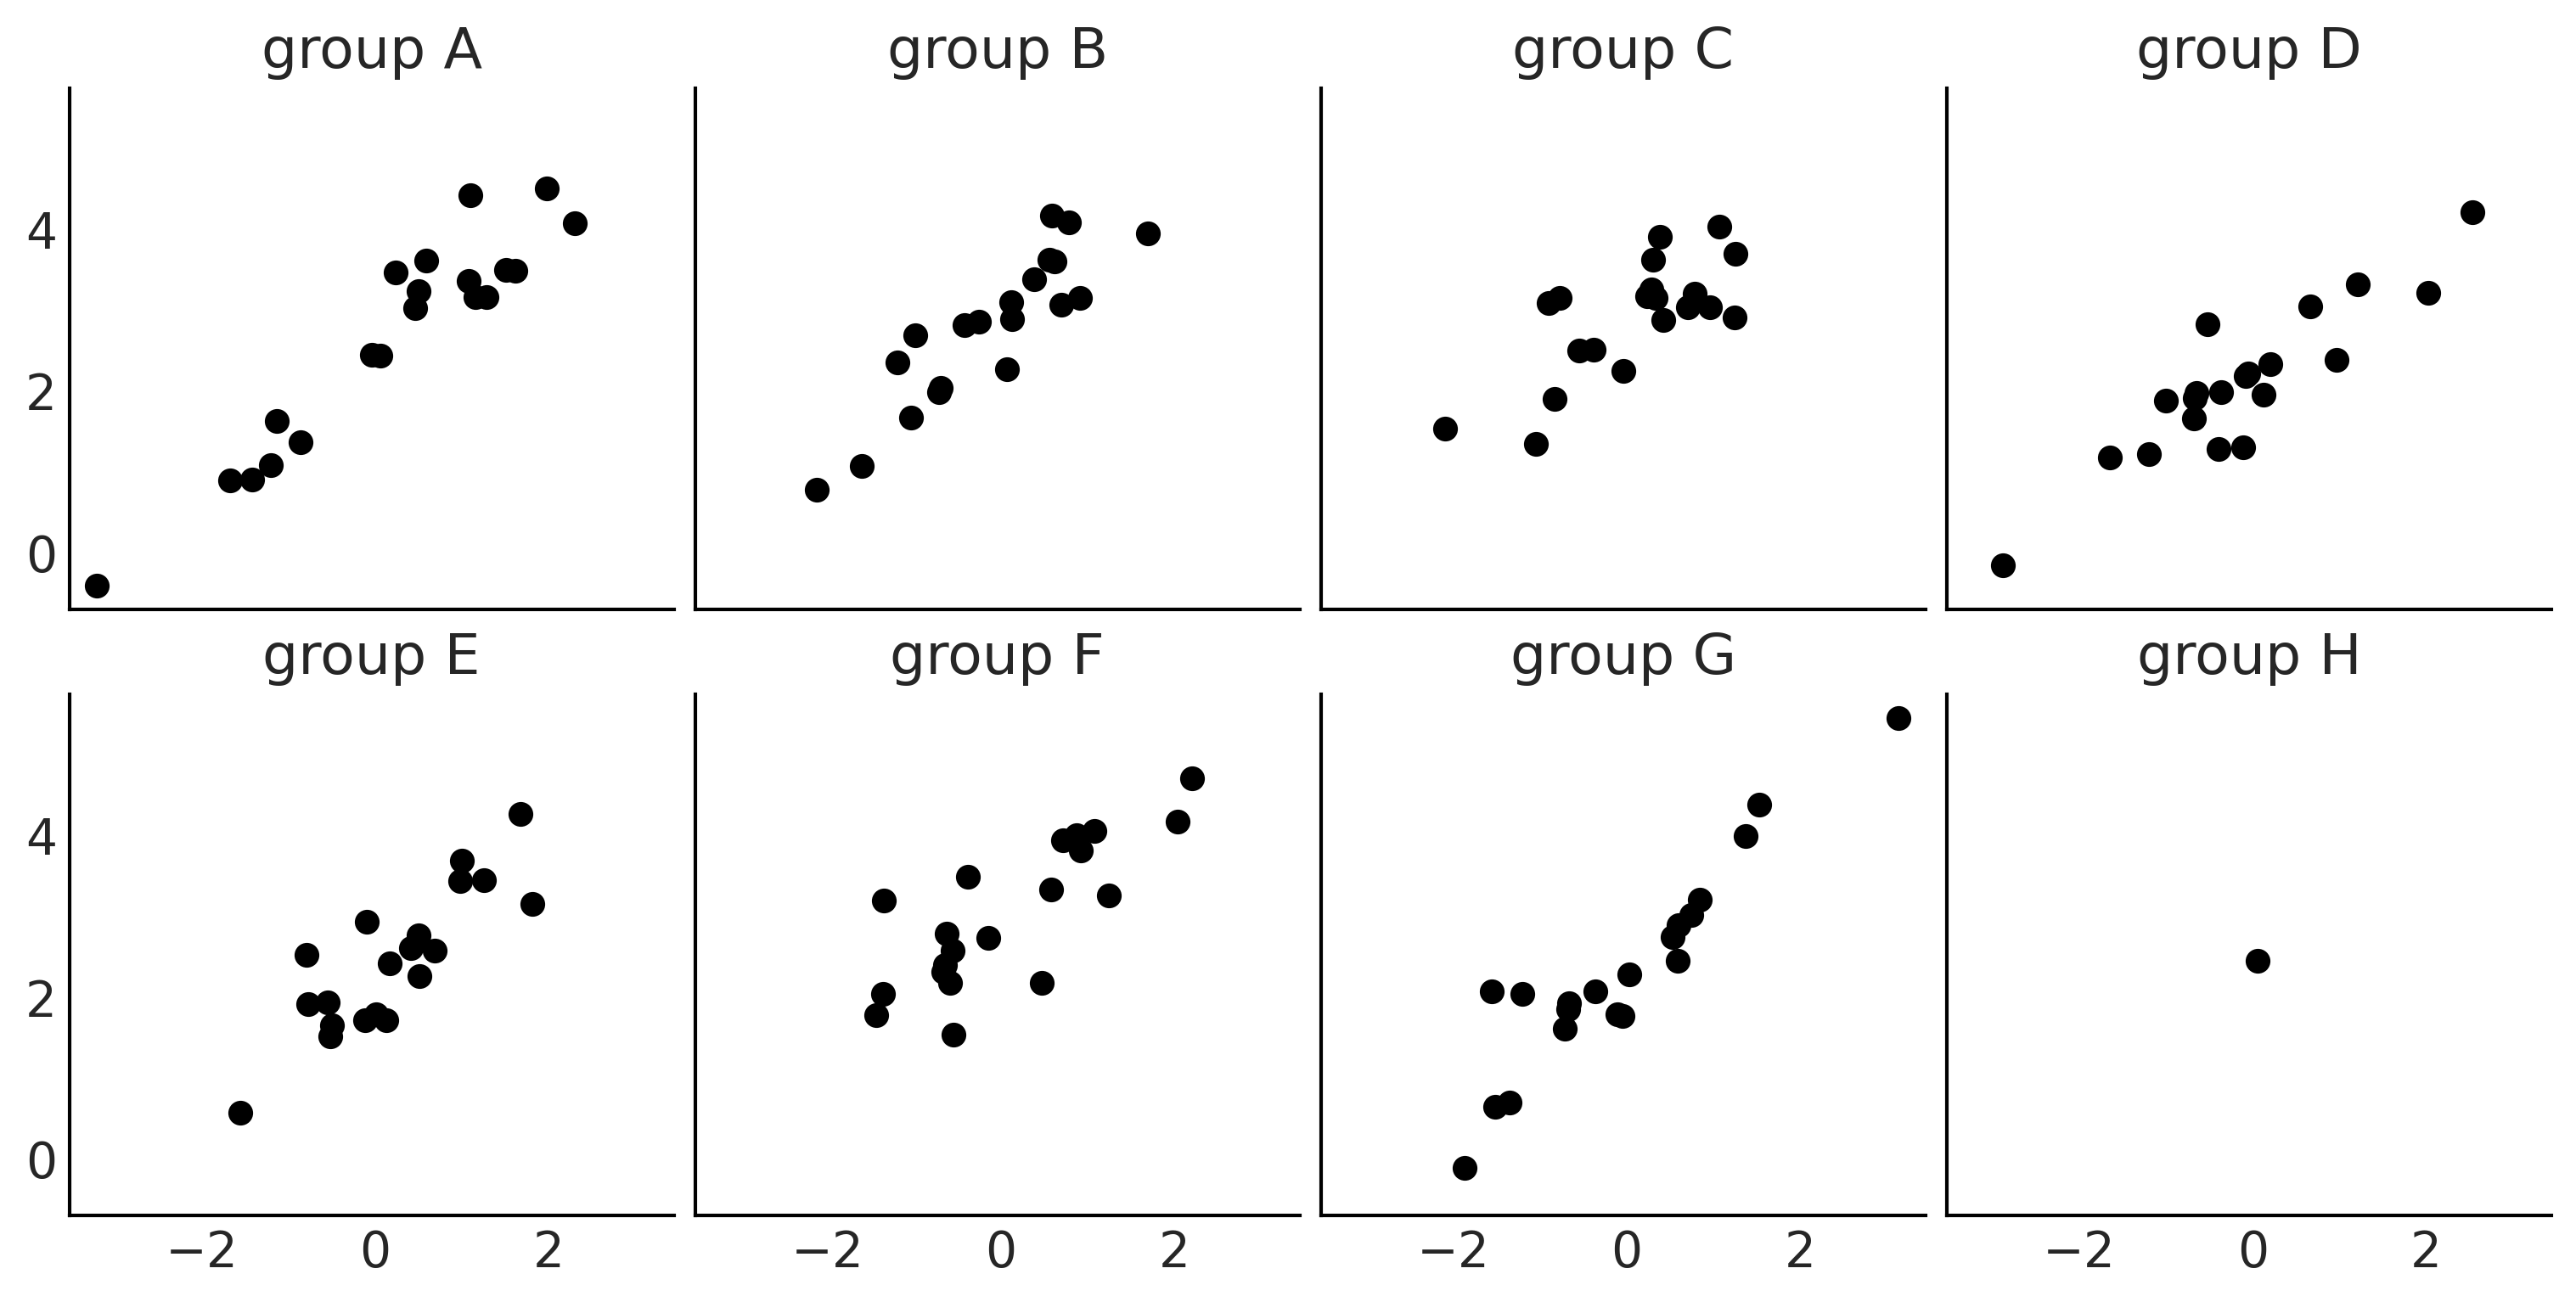

In [16]:
N = 20
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
M = len(groups)
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(0, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_title(f"group {g}")

    j += N
    k += N
plt.savefig("../fig/hierarchical_data.png")

In [19]:
with pm.Model(coords=coords) as hierarchical_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="group")
    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_cen = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.


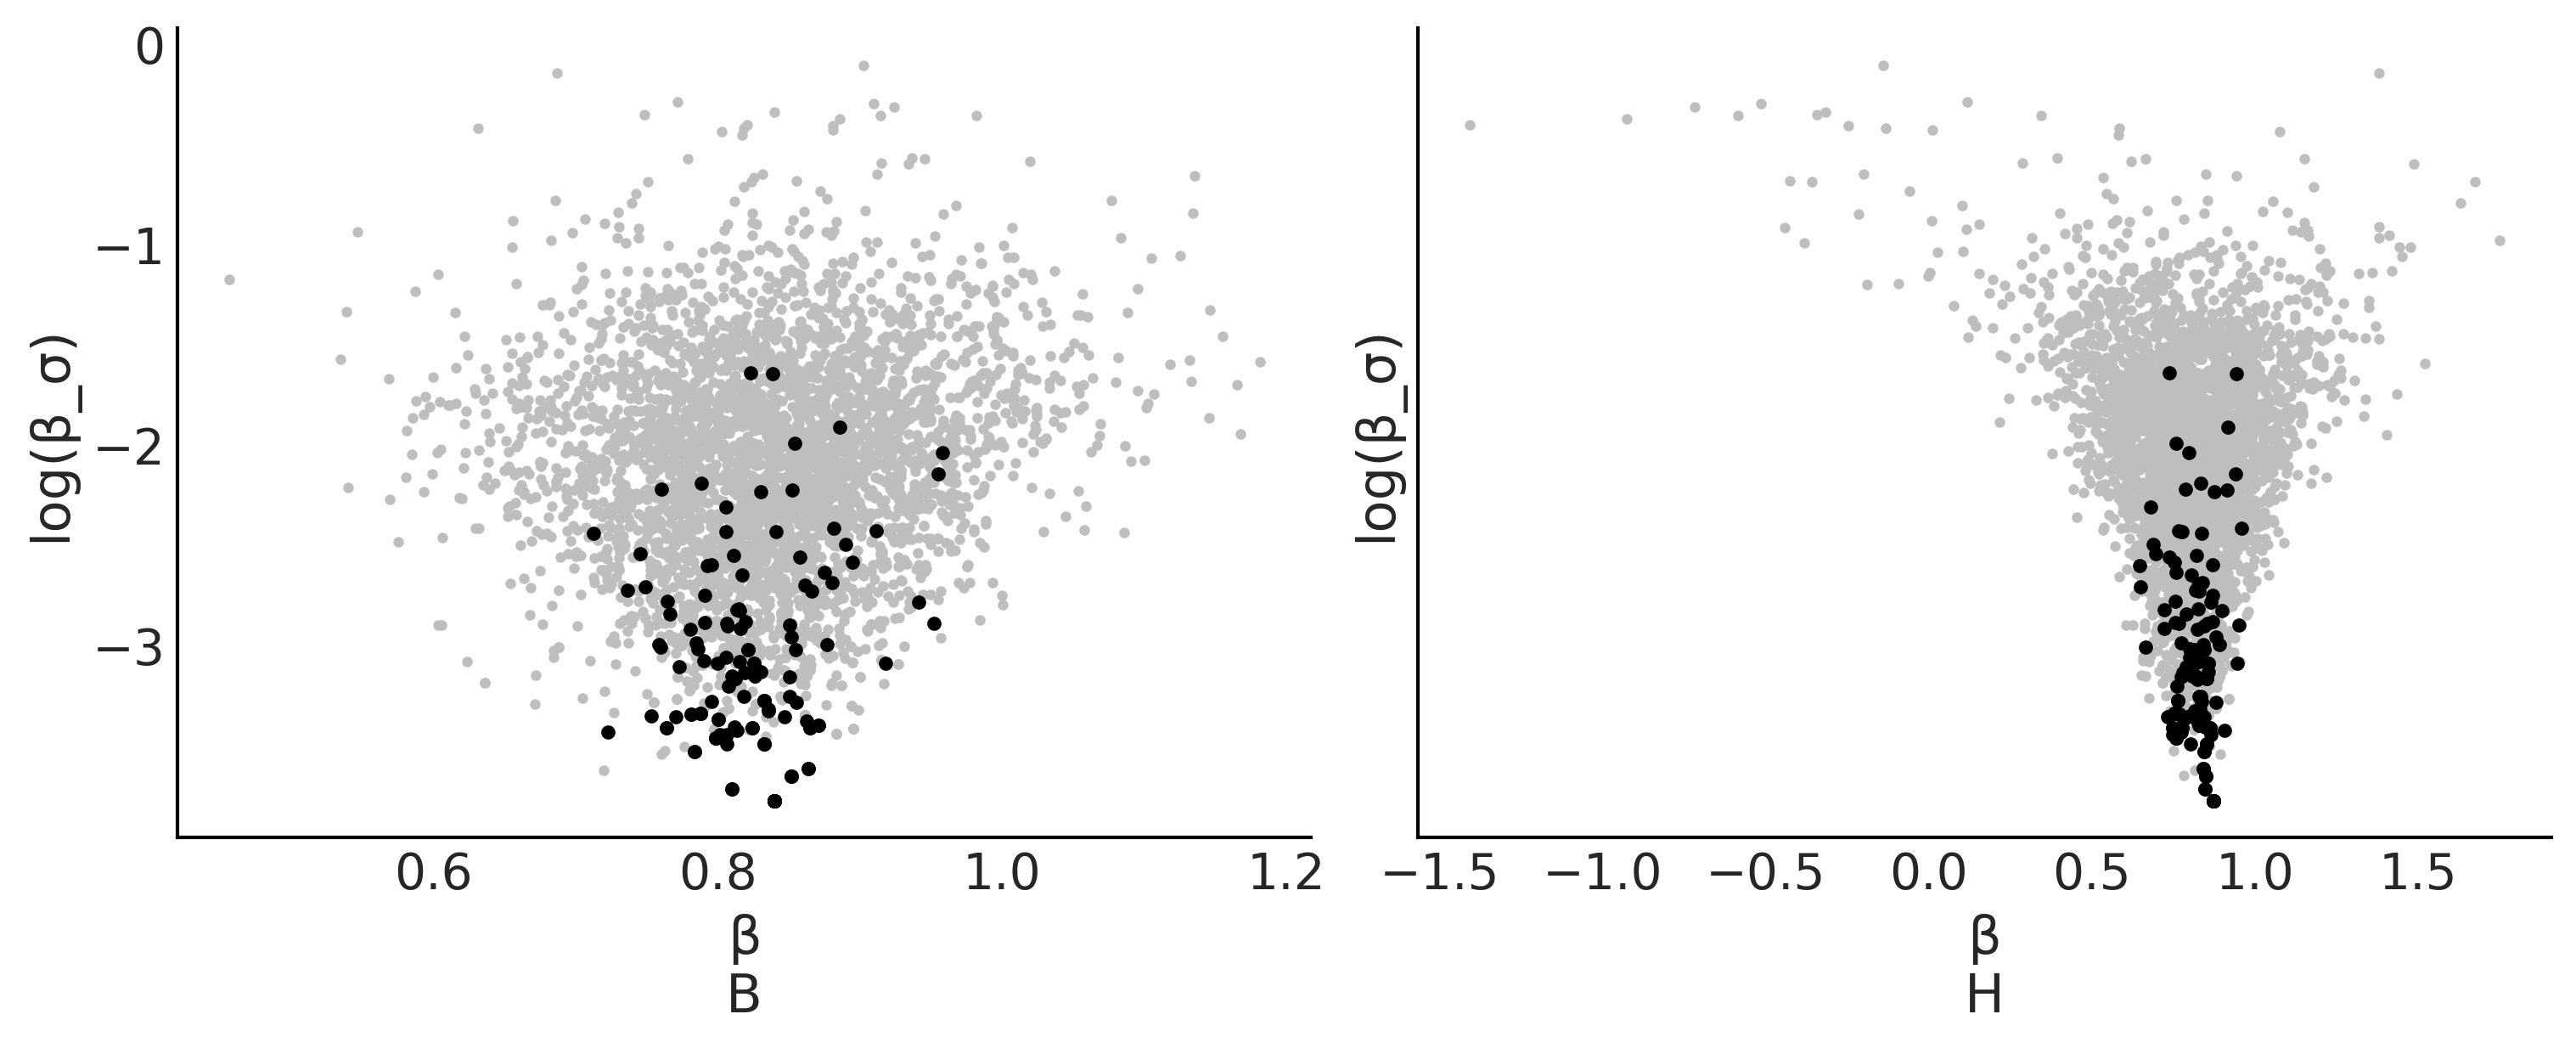

In [20]:
idata_cen.posterior["log(β_σ)"] = np.log(idata_cen.posterior["β_σ"])

_, axes = plt.subplots(1, 2, sharey="row", sharex="col", figsize=(10, 4))

vars = ["log(β_σ)", "log(β_σ)"]
glabel = ["B", "H"]
for ax, var, gl in zip(axes.ravel(), vars, glabel):
    az.plot_pair(
        idata_cen,
        var_names=["β", var],
        coords={"group": [gl]},
        divergences=True,
        scatter_kwargs={"color": "C2"},
        divergences_kwargs={"color": "k", "marker": ".", "mec": None},
        ax=ax,
    )
plt.savefig("../fig/divergences_centered.png")

In [25]:
with pm.Model(coords=coords) as hierarchical_non_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")

    β_offset = pm.Normal("β_offset", mu=0, sigma=1, dims="group")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="group")

    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_ncen = pm.sample(random_seed=123, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β_offset, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


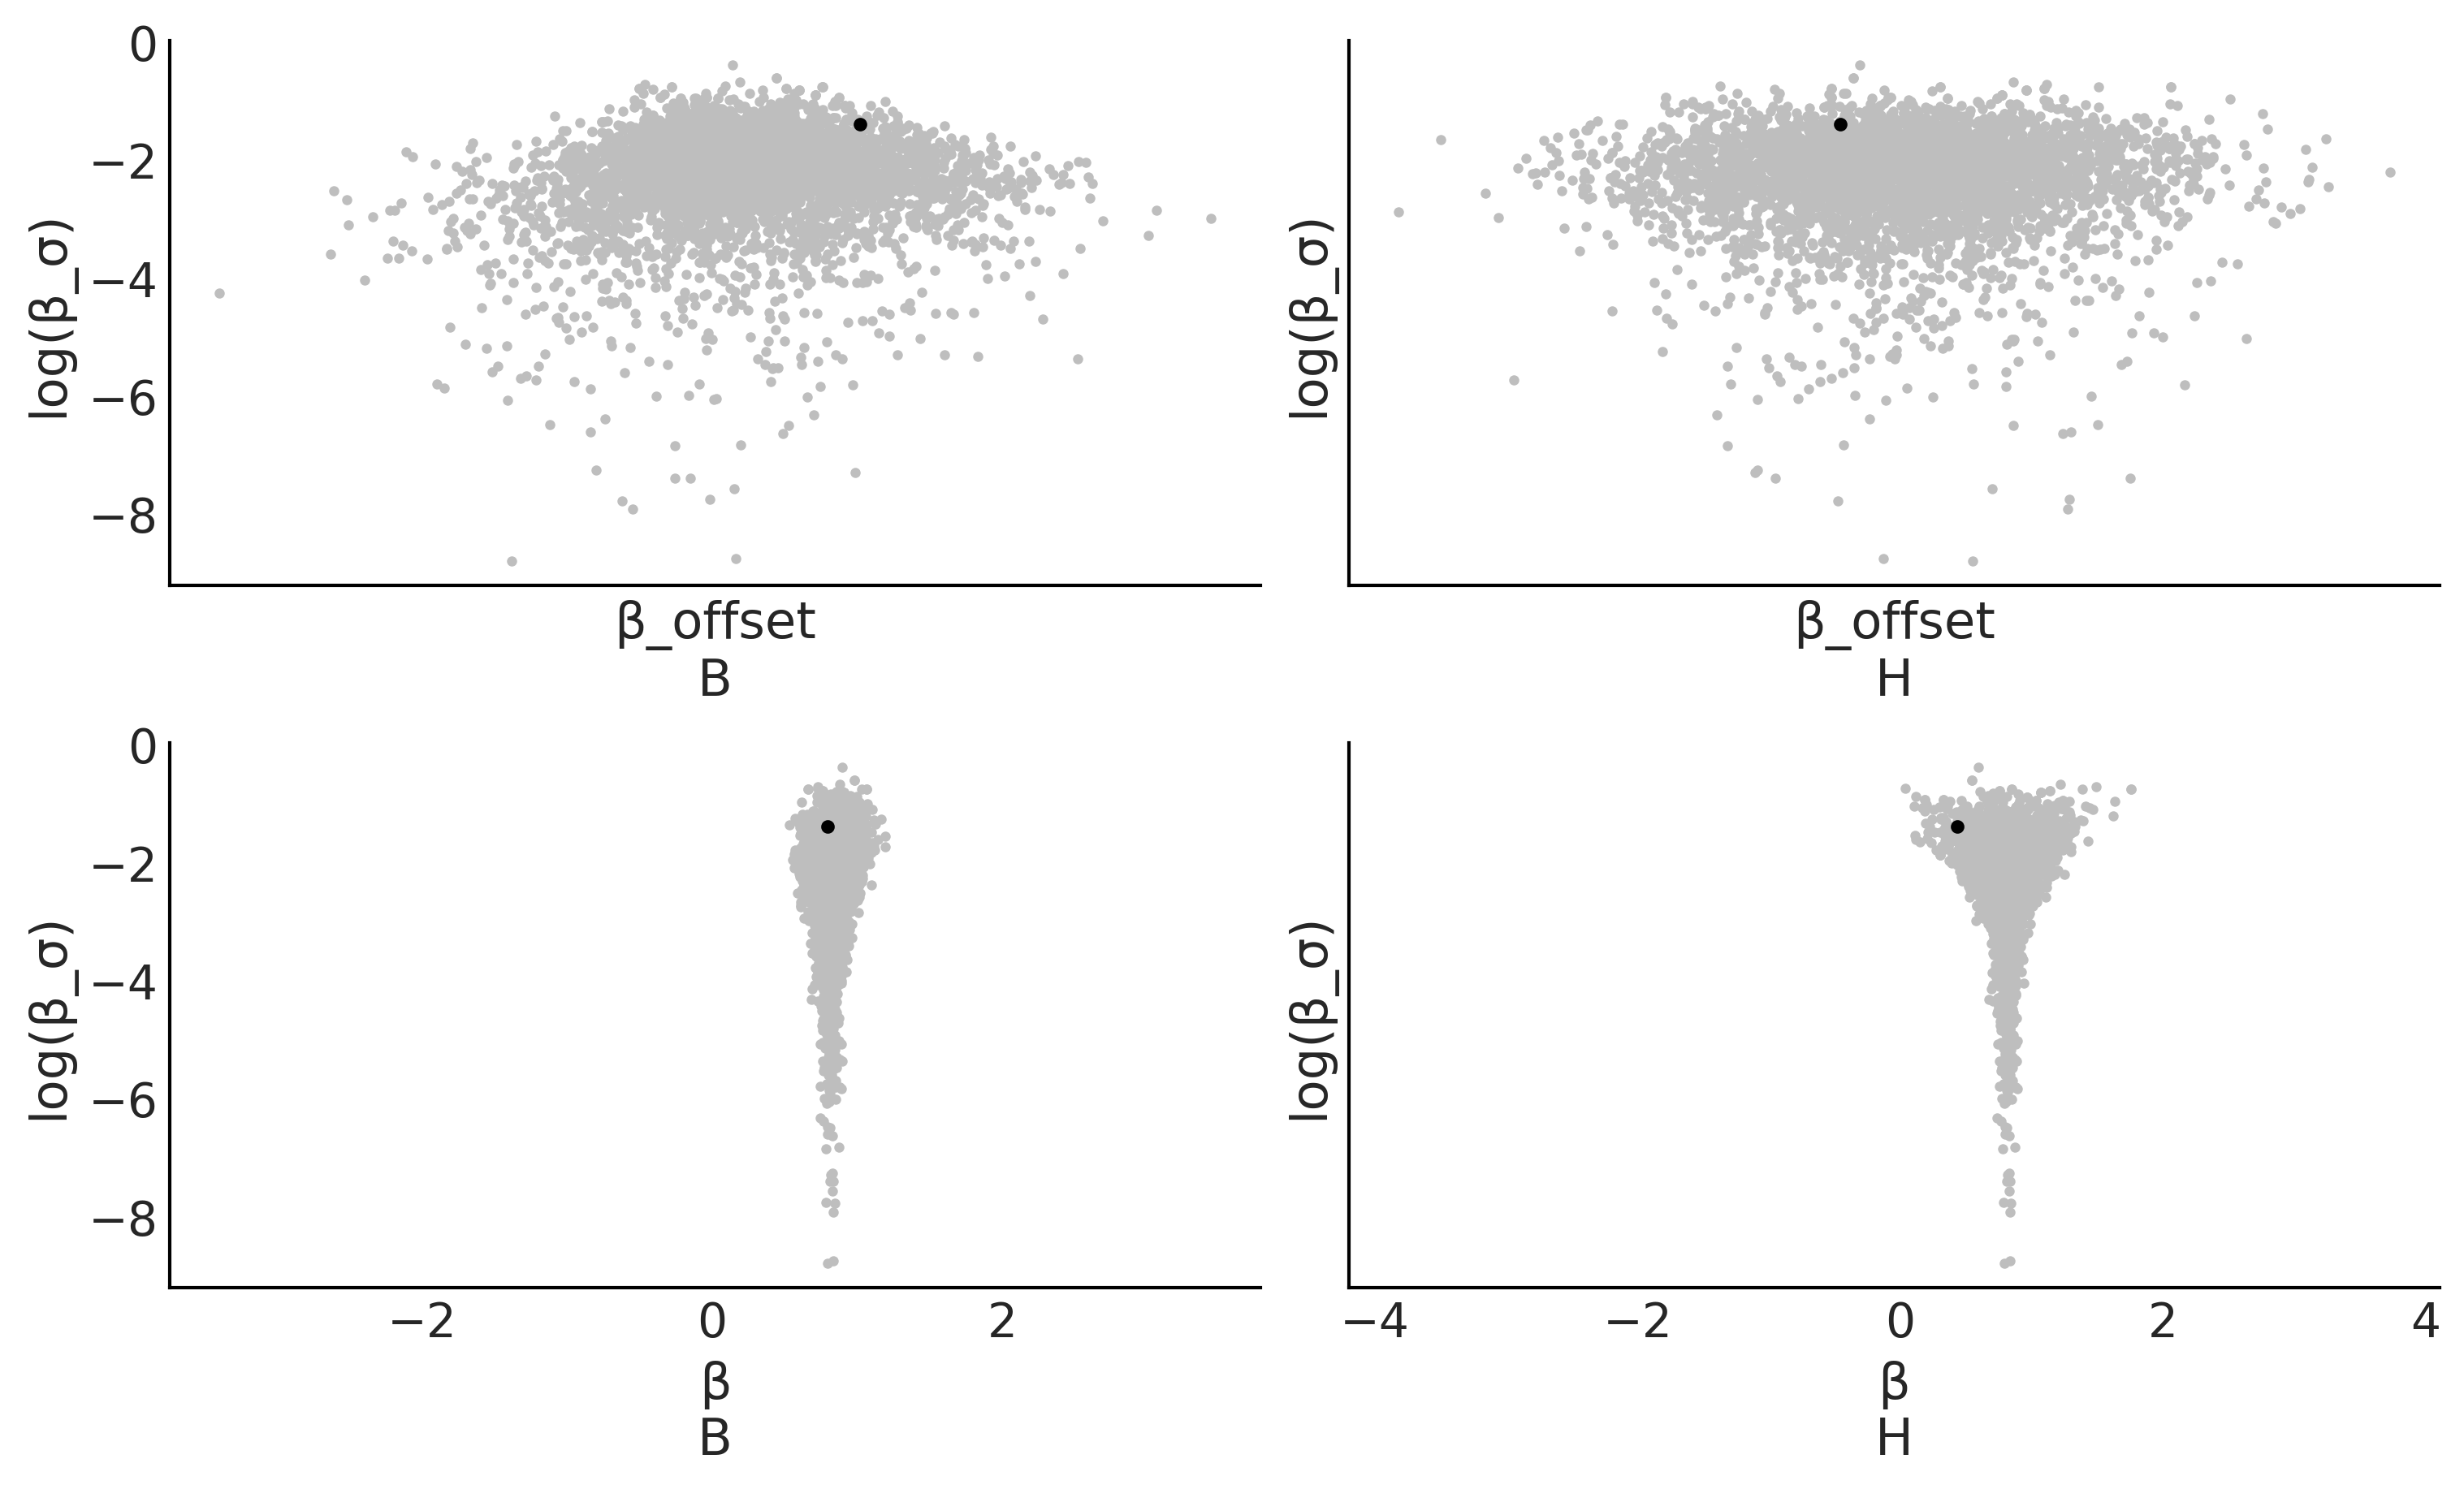

In [22]:
idata_ncen.posterior["log(β_σ)"] = np.log(idata_ncen.posterior["β_σ"])

_, axes = plt.subplots(2, 2, sharey="row", sharex="col", figsize=(10, 6))

vars = np.repeat(["β_offset", "β"], 2)
glabel = ["B", "H"] * 2

for ax, var, gl in zip(axes.ravel(), vars, glabel):
    az.plot_pair(
        idata_ncen,
        var_names=[var, "log(β_σ)"],
        coords={"group": [gl]},
        divergences=True,
        scatter_kwargs={"color": "C2"},
        divergences_kwargs={"color": "k", "marker": ".", "mec": None},
        ax=ax,
    )
plt.savefig("../fig/divergences_non_centered.png")